# Data analysis

In [1]:
import pandas as pd
import os
import re # For regular expressions
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway
import colorsys
import matplotlib.colors as mcolors
import numpy as np
import yaml

# --- Configuration ---
BASE_DIR_3D = '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)'
GROUP_INFO_FILE_3D = '/home/kirill/Desktop/For_Kirill/iba1 Morpho_group.csv'
METRICS_FILENAME_3D = 'metrics_df_ramified.csv'

BASE_DIR_2D = '/home/kirill/Desktop/For_Kirill/microglial distance_2D_tiff (Copy)'
METRICS_FILENAME_2D = 'metrics_df_ramified_2d.csv'

EXPORT_BASE_DIRECTORY = '/home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined'

TITLE_FONTSIZE = 32
AXIS_LABEL_FONTSIZE = 28
TICK_LABEL_FONTSIZE = 24
ANNOTATION_FONTSIZE = 20 # For "n=..." and p-values

if not os.path.exists(EXPORT_BASE_DIRECTORY):
    os.makedirs(EXPORT_BASE_DIRECTORY)
    print(f"Created base export directory: {EXPORT_BASE_DIRECTORY}")

ORIGINAL_CUSTOM_PALETTE = ['#00312F', '#1D2D46', '#46000D', '#5F3920', '#573844', '#424313', '#7A7A30', '#307A7A']
BOXPLOT_WIDTH = 0.3  # Your preferred narrow width
BOXPLOT_LINEWIDTH = 3.0 # Your preferred thick lines
STRIPPLOT_JITTER = BOXPLOT_WIDTH * 0.4 # Jitter relative to the narrow box width (might need adjustment)
STRIPPLOT_SIZE = 8 # Slightly smaller points for narrow boxes
Y_AXIS_PADDING_FACTOR = 1 # Add 20% padding to the top of the y-axis
all_stats_records = []

# --- Helper Functions (make_pastel, format_axis_label, get_significance_asterisks, format_p_value_for_display) ---
def make_pastel(hex_color, lightness_scale=0.7, saturation_scale=0.6):
    try:
        rgb_normalized = mcolors.to_rgb(hex_color)
        h, l, s = colorsys.rgb_to_hls(rgb_normalized[0], rgb_normalized[1], rgb_normalized[2])
        l_pastel = l + (1.0 - l) * lightness_scale; l_pastel = min(1.0, max(0.0, l_pastel))
        s_pastel = s * saturation_scale; s_pastel = min(1.0, max(0.0, s_pastel))
        rgb_pastel_normalized = colorsys.hls_to_rgb(h, l_pastel, s_pastel)
        return mcolors.to_hex(rgb_pastel_normalized)
    except ValueError: return hex_color

def format_axis_label(label_text):
    parts = label_text.split('_'); formatted_parts = []
    for part in parts:
        part_lower = part.lower()
        if part_lower == "um": formatted_parts.append("µm" + part[2:])
        elif part_lower == "um2": formatted_parts.append("µm²")
        elif part_lower == "um3": formatted_parts.append("µm³")
        else: formatted_parts.append(part.capitalize())
    return " ".join(formatted_parts)

def get_significance_asterisks(p_value):
    if p_value is None: return ""
    if p_value < 0.001: return "***"
    if p_value < 0.01: return "**"
    if p_value < 0.05: return "*"
    return "n.s."

def format_p_value_for_display(p_value):
    if p_value is None: return ""
    sig = get_significance_asterisks(p_value)
    if sig == "n.s.": return f"n.s. (p={p_value:.3f})"
    if p_value < 0.001: return f"p < 0.001{sig}"
    return f"p={p_value:.3f}{sig}"

PASTEL_PALETTE = [make_pastel(color) for color in ORIGINAL_CUSTOM_PALETTE]
# --- END Helper Functions ---

# --- Data Loading and Processing Function ---
def load_and_process_dataset(dataset_name_tag, base_dir, metrics_filename, 
                             image_dir_pattern_func,
                             group_assignment_df_external=None, 
                             derive_group_from_image_id_func=None):
    print(f"\n--- Loading Dataset: {dataset_name_tag} ---")
    all_metrics_data = []
    if not os.path.isdir(base_dir):
        print(f"ERROR: Base directory '{base_dir}' for {dataset_name_tag} not found.")
        return pd.DataFrame()
    try:
        potential_dirs = os.listdir(base_dir)
        image_id_dirs = sorted([d for d in potential_dirs if image_dir_pattern_func(d, base_dir)])
    except Exception as e:
        print(f"ERROR: Could not list or filter directories in '{base_dir}': {e}")
        return pd.DataFrame()
    print(f"Found {len(image_id_dirs)} potential image directories for {dataset_name_tag}.")

    for image_id in image_id_dirs:
        processed_folder_name = f"{image_id}_processed_{metrics_filename.replace('metrics_df_', '').replace('.csv', '')}"
        metrics_file_path = os.path.join(base_dir, image_id, processed_folder_name, metrics_filename)
        
        if os.path.exists(metrics_file_path):
            try:
                df = pd.read_csv(metrics_file_path)
                if df.empty: continue
                df['Image_ID_Full'] = image_id 
                df['Dataset_Tag'] = dataset_name_tag
                if derive_group_from_image_id_func:
                    df['Experimental_Group'] = df['Image_ID_Full'].apply(derive_group_from_image_id_func)
                all_metrics_data.append(df)
            except Exception as e:
                print(f"Error loading metrics for {image_id} from {metrics_file_path}: {e}. Skipping.")
    if not all_metrics_data:
        print(f"No metrics data loaded for {dataset_name_tag}.")
        return pd.DataFrame()
    dataset_df = pd.concat(all_metrics_data, ignore_index=True)
    
    if group_assignment_df_external is not None:
        # This function now expects the group assignment df to have 'Image_ID', 'Experimental_Group', and 'Batch'
        dataset_df['Image_ID_For_Merge'] = dataset_df['Image_ID_Full']
        dataset_df = pd.merge(dataset_df, group_assignment_df_external, 
                              left_on='Image_ID_For_Merge', right_on='Image_ID',
                              how='left', suffixes=('', '_external'))
        
        # Consolidate 'Experimental_Group' and 'Batch'
        for col in ['Experimental_Group', 'Batch']:
            external_col = f'{col}_external'
            if external_col in dataset_df.columns:
                if col not in dataset_df.columns:
                    dataset_df[col] = dataset_df[external_col]
                else:
                    dataset_df[col] = np.where(dataset_df[external_col].notna(), 
                                               dataset_df[external_col], 
                                               dataset_df[col])
                dataset_df.drop(columns=[external_col], inplace=True)

        if 'Image_ID_For_Merge' in dataset_df.columns: dataset_df.drop(columns=['Image_ID_For_Merge'], inplace=True)
        if 'Image_ID_y' in dataset_df.columns: dataset_df.drop(columns=['Image_ID_y'], inplace=True)
        if 'Image_ID_x' in dataset_df.columns: dataset_df.rename(columns={'Image_ID_x':'Image_ID'}, inplace=True)

    if 'Experimental_Group' not in dataset_df.columns or dataset_df['Experimental_Group'].isnull().all():
        print(f"Warning: No experimental groups assigned or derived for {dataset_name_tag}. Assigning 'DefaultGroup'.")
        dataset_df['Experimental_Group'] = f"{dataset_name_tag}_DefaultGroup"
    
    # Ensure Batch column exists, even if it's just a default
    if 'Batch' not in dataset_df.columns:
        dataset_df['Batch'] = dataset_df['Image_ID_Full'] # Each image is its own "batch" if no info

    print(f"Finished loading {dataset_name_tag}: {len(dataset_df)} total cells from {dataset_df['Image_ID_Full'].nunique()} images.")
    print(f"Value counts for Experimental_Group in {dataset_name_tag}:\n{dataset_df['Experimental_Group'].value_counts(dropna=False)}")
    return dataset_df

def is_3d_image_dir(dir_name, base_path):
    """
    Checks if a directory is a valid 3D image directory.
    A directory is considered 3D if it contains a 'ramified_config.yaml' file
    with a 'voxel_dimensions' key.
    """
    # Assuming the config file is named 'ramified_config.yaml' and is at the top level of the image directory
    config_file_path = os.path.join(base_path, dir_name, 'ramified_config.yaml')
    
    if not os.path.exists(config_file_path):
        return False
        
    try:
        with open(config_file_path, 'r') as f:
            config_data = yaml.safe_load(f)
        
        # Check if config_data is a dictionary and contains the key
        if isinstance(config_data, dict) and 'voxel_dimensions' in config_data:
            return True
            
    except yaml.YAMLError as e:
        print(f"Warning: Could not parse YAML file '{config_file_path}': {e}")
    except Exception as e:
        print(f"Warning: Error reading file '{config_file_path}': {e}")
        
    return False

def is_2d_image_dir(dir_name, base_path):
    """
    Checks if a directory is a valid 2D image directory.
    A directory is considered 2D if it contains a 'ramified_config.yaml' file
    with a 'pixel_dimensions' key.
    """
    # Assuming the config file is named 'ramified_config.yaml' for consistency
    config_file_path = os.path.join(base_path, dir_name, 'ramified_config_2d.yaml')
    
    if not os.path.exists(config_file_path):
        return False
        
    try:
        with open(config_file_path, 'r') as f:
            config_data = yaml.safe_load(f)

        # Check if config_data is a dictionary and contains the key
        if isinstance(config_data, dict) and 'pixel_dimensions' in config_data:
            return True

    except yaml.YAMLError as e:
        print(f"Warning: Could not parse YAML file '{config_file_path}': {e}")
    except Exception as e:
        print(f"Warning: Error reading file '{config_file_path}': {e}")

    return False

def derive_2d_group(image_id_full):
    """Derives the batch ('1st', '2nd', etc.) from the 2D image filename."""
    # This regex now correctly finds the batch identifier like '1st', '2nd', '5th'
    # from filenames like 'iba1-1st_5'
    match = re.search(r"iba1-(\d+(?:st|nd|rd|th))", image_id_full)
    if match:
        # We return the batch identifier, e.g., '1st', '2nd'. This will be our 'Experimental_Group'
        # which acts as the biological replicate batch for 2D.
        return match.group(1)
    return "2D_Other" # Fallback

# --- (CORRECTED) Central function to run all statistical tests upfront ---
def run_all_statistics(metrics_to_test, agg_data, dataset_tag_str, valid_groups_list):
    """
    Runs all statistical tests for a given dataset and returns a LIST of result dictionaries.
    """
    # *** CHANGE: Initialize as a list, not a dictionary ***
    stats_records = []
    
    if agg_data.empty:
        return stats_records

    for metric_col_name in metrics_to_test:
        if metric_col_name not in agg_data.columns:
            continue

        p_val = None
        s_stat = None
        test_type = 'None'
        comparison_str = 'N/A'
        
        # Determine the formatted metric name here for consistency
        formatted_metric_name = "Total Number of Cells" if metric_col_name == 'num_cells' else f"Avg {format_axis_label(metric_col_name)}"

        if len(valid_groups_list) == 2:
            g1n, g2n = valid_groups_list[0], valid_groups_list[1]
            g1d = agg_data[agg_data['Experimental_Group'] == g1n][metric_col_name].dropna()
            g2d = agg_data[agg_data['Experimental_Group'] == g2n][metric_col_name].dropna()
            if len(g1d) >= 2 and len(g2d) >= 2:
                s_stat, p_val = ttest_ind(g1d, g2d, nan_policy='omit', equal_var=False)
                test_type = 'T-test'
                comparison_str = f"{g1n} vs {g2n}"
        
        elif len(valid_groups_list) > 2:
            samples_anova = [d[metric_col_name].dropna() for _, d in agg_data[agg_data['Experimental_Group'].isin(valid_groups_list)].groupby('Experimental_Group')]
            valid_samples_anova = [s for s in samples_anova if len(s) >= 2]
            if len(valid_samples_anova) == len(agg_data[agg_data['Experimental_Group'].isin(valid_groups_list)]['Experimental_Group'].unique()):
                s_stat, p_val = f_oneway(*valid_samples_anova)
                test_type = 'ANOVA'
                comparison_str = f"Across {len(valid_groups_list)} groups"

        if p_val is not None:
            # *** CHANGE: Append a dictionary to the list ***
            stats_records.append({
                'Dataset': dataset_tag_str,
                'Metric': formatted_metric_name, # Use the consistent formatted name
                'Raw_Metric': metric_col_name, # Store the raw metric name for easier lookup
                'Comparison': comparison_str,
                'Test': test_type,
                'Statistic': f"{s_stat:.3f}",
                'P_Value': p_val, # Store the raw p-value
            })
            
    return stats_records

# --- (NEW) Helper function for correlation heatmaps ---
def plot_correlation_heatmap(df, metrics_list, dataset_tag_str, export_directory_path):
    """Calculates and plots a correlation heatmap for a given list of metrics."""
    print(f"\n--- ({dataset_tag_str}) Exploratory Correlation Analysis ---")
    
    # Select only the metrics that exist in the dataframe
    metrics_to_correlate = [m for m in metrics_list if m in df.columns]
    if len(metrics_to_correlate) < 2:
        print("Not enough metrics to create a correlation heatmap.")
        return
        
    correlation_matrix = df[metrics_to_correlate].corr()
    
    # Create formatted labels for the heatmap
    formatted_labels = [format_axis_label(m) for m in metrics_to_correlate]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix, 
        annot=True,          # Show the correlation values
        fmt=".2f",           # Format to 2 decimal places
        cmap='coolwarm',     # Use a diverging colormap
        linewidths=.5,
        ax=ax,
        xticklabels=formatted_labels,
        yticklabels=formatted_labels
    )
    ax.set_title(f'({dataset_tag_str}) Correlation Matrix of Morphological Metrics')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    pdf_path = os.path.join(export_directory_path, f'correlation_heatmap_{dataset_tag_str}.pdf')
    plt.savefig(pdf_path, format='pdf', bbox_inches='tight')
    plt.close(fig)
    print(f"Saved correlation heatmap: {pdf_path}")

def plot_metric_boxplot(metric_col_name, data_df_source, dataset_tag_str, plot_title_suffix, 
                        export_directory_path, 
                        valid_groups_list, palette_map_orig_func, palette_map_pastel_func,
                        raw_p_value=None, corrected_p_value=None,
                        y_label_override=None, is_pre_aggregated=False):

    # Generate palettes based on the specific valid_groups_list for this plot
    palette_map_orig = palette_map_orig_func(valid_groups_list)
    palette_map_pastel = palette_map_pastel_func(valid_groups_list)

    print(f"--- ({dataset_tag_str}) Plotting {format_axis_label(metric_col_name)} ---")
    
    if metric_col_name not in data_df_source.columns or not valid_groups_list:
        print(f"Skipping plot for {format_axis_label(metric_col_name)} in {dataset_tag_str}: column missing or no valid groups.")
        return

    # Boxplot
    if is_pre_aggregated:
        agg_data = data_df_source.copy()
        if 'Comparison_Group' in agg_data.columns and 'Experimental_Group' not in agg_data.columns:
            agg_data = agg_data.rename(columns={'Comparison_Group': 'Experimental_Group'})
        elif 'Comparison_Group' in agg_data.columns and 'Experimental_Group' in agg_data.columns:
            if agg_data['Experimental_Group'].isnull().all() and not agg_data['Comparison_Group'].isnull().all():
                agg_data.drop(columns=['Experimental_Group'], inplace=True)
                agg_data.rename(columns={'Comparison_Group': 'Experimental_Group'}, inplace=True)
    else:
        id_col_for_agg = 'Image_ID_Full' if 'Image_ID_Full' in data_df_source.columns else 'Image_ID'
        if id_col_for_agg not in data_df_source.columns or 'Experimental_Group' not in data_df_source.columns:
             print(f"ERROR: Cannot aggregate for boxplot {metric_col_name} in {dataset_tag_str}, missing ID or Group column.")
             return
        agg_data = data_df_source.groupby([id_col_for_agg, 'Experimental_Group'])[metric_col_name].mean().reset_index()
    
    agg_data = agg_data.dropna(subset=['Experimental_Group', metric_col_name])
    if agg_data.empty:
        print(f"No aggregated data to plot for {metric_col_name} in {dataset_tag_str}.")
        return
        
    n_counts = agg_data['Experimental_Group'].value_counts().reindex(valid_groups_list).fillna(0).astype(int)

    # Dynamic figure width for boxplots
    num_groups = len(valid_groups_list)
    if num_groups <= 3:
        fig_width = max(8, num_groups * 1.5)
    elif num_groups <=5:
        fig_width = num_groups * 1.2
    else:
        fig_width = num_groups * 1.0
    fig_width = min(fig_width, 12)

    fig_box, ax_box = plt.subplots(figsize=(fig_width, 6))
    
    box_plot_hue_order = [g for g in valid_groups_list if g in palette_map_pastel]
    if not box_plot_hue_order and valid_groups_list: box_plot_hue_order = valid_groups_list

    sns.boxplot(data=agg_data, x='Experimental_Group', y=metric_col_name, order=box_plot_hue_order, 
                palette={g: palette_map_pastel.get(g, '#dddddd') for g in box_plot_hue_order}, 
                showfliers=False, width=BOXPLOT_WIDTH, linewidth=BOXPLOT_LINEWIDTH, ax=ax_box)
    
    for g_name_plot in box_plot_hue_order:
        current_g_data_plot = agg_data[agg_data['Experimental_Group'] == g_name_plot]
        if not current_g_data_plot.empty:
            sns.stripplot(data=current_g_data_plot, x='Experimental_Group', y=metric_col_name, 
                          order=box_plot_hue_order, 
                          color=palette_map_orig.get(g_name_plot, '#333333'), 
                          alpha=0.9, jitter=STRIPPLOT_JITTER, size=STRIPPLOT_SIZE, ax=ax_box, dodge=False)
    
    y_max_overall = agg_data[metric_col_name].max() if not agg_data[metric_col_name].empty else 0
    min_overall_data = agg_data[metric_col_name].min() if not agg_data[metric_col_name].empty else 0
    max_n_text_y = -np.inf

    for i, g_name_text in enumerate(box_plot_hue_order):
        n_val = n_counts.get(g_name_text, 0)
        g_points = agg_data[agg_data['Experimental_Group'] == g_name_text][metric_col_name]
        text_y_val = y_max_overall * 1.02
        if not g_points.empty:
            q75 = g_points.quantile(0.75); iqr = q75 - g_points.quantile(0.25)
            upper_w = q75 + 1.5 * iqr if iqr > 0 else q75
            max_strip = g_points.max() if not g_points.empty else q75
            text_y_val = max(upper_w, max_strip) * 1.05 
            if text_y_val == 0 and y_max_overall == 0: text_y_val = 0.05 * (abs(min_overall_data) if min_overall_data !=0 else 1)
        elif y_max_overall == 0: text_y_val = 0.05 * (abs(min_overall_data) if min_overall_data !=0 else 1)
        
        ax_box.text(i, text_y_val, f"n={n_val}", ha='center', va='bottom', fontsize=ANNOTATION_FONTSIZE)
        max_n_text_y = max(max_n_text_y, text_y_val if text_y_val is not None else -np.inf)

    ax_box.set_title(f'({dataset_tag_str}) Avg {format_axis_label(metric_col_name)} {plot_title_suffix}', fontsize=TITLE_FONTSIZE)
    ax_box.set_xlabel('', fontsize=AXIS_LABEL_FONTSIZE)
    ax_box.set_ylabel(y_label_override if y_label_override else f'Avg {format_axis_label(metric_col_name)}', fontsize=AXIS_LABEL_FONTSIZE)
    
    ax_box.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
    
    y_lim_top = max_n_text_y * 1.05 if max_n_text_y > -np.inf else y_max_overall * 1.1 
    if y_lim_top <= 0 : y_lim_top = (y_max_overall if y_max_overall > 0 else 1) * 1.1

    if corrected_p_value is not None and len(box_plot_hue_order) == 2:
        g1n, g2n = box_plot_hue_order[0], box_plot_hue_order[1]
        g1d = agg_data[agg_data['Experimental_Group'] == g1n][metric_col_name].dropna()
        g2d = agg_data[agg_data['Experimental_Group'] == g2n][metric_col_name].dropna()
        display_text = format_p_value_for_display(corrected_p_value)
        
        current_max_data_for_bar = max(g1d.max() if not g1d.empty else 0, g2d.max() if not g2d.empty else 0)
        y_bar_start_ref = max_n_text_y if max_n_text_y > -np.inf else current_max_data_for_bar
        y_bar = y_bar_start_ref * 1.08 
        y_bar = max(y_bar, current_max_data_for_bar * 1.15) 
        if y_bar <= 0: y_bar = (current_max_data_for_bar if current_max_data_for_bar > 0 else 1) * 1.15

        t_level = y_bar * 1.05 
        if t_level <= 0: t_level = y_bar + (abs(y_bar) * 0.05 if y_bar != 0 else 0.05)

        tick_h_abs = (y_bar - (max_n_text_y if max_n_text_y > -np.inf and max_n_text_y > 0 else y_bar*0.9)) * 0.1 
        if tick_h_abs <= 0: tick_h_abs = y_bar * 0.02 if y_bar != 0 else 0.002
        
        ax_box.plot([0,1],[y_bar,y_bar],lw=1.5,c='k'); 
        ax_box.plot([0,0],[y_bar-tick_h_abs,y_bar],lw=1.5,c='k'); 
        ax_box.plot([1,1],[y_bar-tick_h_abs,y_bar],lw=1.5,c='k')
        ax_box.text(0.5, t_level, display_text, ha='center', va='bottom', fontsize=ANNOTATION_FONTSIZE)
        y_lim_top = max(y_lim_top, t_level * 1.05) if t_level is not None else y_lim_top

    _, current_ylim_t = ax_box.get_ylim()
    bottom_limit = 0
    if min_overall_data < 0:
        bottom_limit = min_overall_data * 1.1
    
    new_top_limit = max(current_ylim_t, y_lim_top) * Y_AXIS_PADDING_FACTOR
    
    if new_top_limit <= bottom_limit:
        new_top_limit = bottom_limit + (abs(bottom_limit) * 0.1 if bottom_limit != 0 else 0.1)
    
    ax_box.set_ylim(bottom=bottom_limit, top=new_top_limit)
    
    plt.tight_layout()
    
    # --- CHANGE HERE: Export only the relevant columns to CSV ---
    # Define the columns that are essential for this plot
    # The group column is always 'Experimental_Group' at this stage
    # The metric column is metric_col_name
    # We also might want to include the original biological replicate identifier
    export_cols = ['Experimental_Group', metric_col_name]
    
    # Check if a replicate ID column like 'Batch' exists and add it for context
    if 'Batch' in agg_data.columns:
        export_cols.insert(0, 'Batch') # Add 'Batch' to the beginning if it exists
    
    # Filter the dataframe to only include these columns for export
    df_to_export = agg_data[export_cols]

    csv_path_box = os.path.join(export_directory_path, f'data_{dataset_tag_str}_{metric_col_name}.csv')
    df_to_export.to_csv(csv_path_box, index=False, float_format='%.5g') # Using .5g for good precision
    print(f"Saved data to: {csv_path_box}")
    # --- END OF CHANGE ---

    # Export Figure to PDF
    pdf_path_box = os.path.join(export_directory_path, f'boxplot_{dataset_tag_str}_{metric_col_name}.pdf')
    plt.savefig(pdf_path_box, format='pdf', bbox_inches='tight'); plt.close(fig_box)
    print(f"Saved figure to: {pdf_path_box}")

# --- Palette generation functions (to pass to plotting function) ---
def get_original_palette(groups):
    return {g: ORIGINAL_CUSTOM_PALETTE[i % len(ORIGINAL_CUSTOM_PALETTE)] for i, g in enumerate(groups)}
def get_pastel_palette(groups):
    return {g: PASTEL_PALETTE[i % len(PASTEL_PALETTE)] for i, g in enumerate(groups)}

# --- Main Analysis Script ---
# 1. Load 3D Data
group_df_3d = None
try:
    group_df_raw_3d = pd.read_csv(GROUP_INFO_FILE_3D)
    group_df_raw_3d = group_df_raw_3d.rename(columns={'Unnamed: 0': 'Batch'})
    group_name_map = {'Group1': 'Assembled Together', 'Group2': 'Added Later'}
    melted_dfs = []
    for group_col_name, desc_group_name in group_name_map.items():
        group_subset = group_df_raw_3d[['Batch', group_col_name]].dropna(subset=[group_col_name])
        group_subset = group_subset.rename(columns={group_col_name: 'Image_ID'})
        group_subset['Experimental_Group'] = desc_group_name
        melted_dfs.append(group_subset)
    group_df_3d = pd.concat(melted_dfs, ignore_index=True)
    group_df_3d['Image_ID'] = group_df_3d['Image_ID'].astype(str).str.strip()
except Exception as e_3d_group:
    print(f"Warning: Could not load or process 3D group assignments from '{GROUP_INFO_FILE_3D}': {e_3d_group}")

data_3d_df = load_and_process_dataset("3D", BASE_DIR_3D, METRICS_FILENAME_3D, is_3d_image_dir, group_assignment_df_external=group_df_3d)
data_2d_df = load_and_process_dataset("2D", BASE_DIR_2D, METRICS_FILENAME_2D, is_2d_image_dir, derive_group_from_image_id_func=derive_2d_group)

# ------------------------------------------------------------------
# MODIFIED WORKFLOW: Define tasks, then loop to run stats, correct, and plot.
# ------------------------------------------------------------------

analysis_tasks = []

# --- Task 1: 3D Standalone Analysis ---
if not data_3d_df.empty:
    export_dir_3d = os.path.join(EXPORT_BASE_DIRECTORY, "3D_Analysis_by_Batch")
    if not os.path.exists(export_dir_3d): os.makedirs(export_dir_3d)
    all_3d_metrics_for_corr = ['shortest_distance_um', 'true_num_branches', 'skan_total_length_um', 'skan_avg_branch_length_um', 'true_num_junctions', 'true_num_endpoints', 'sphericity', 'volume_um3']
    plot_correlation_heatmap(data_3d_df, all_3d_metrics_for_corr, "3D_per_cell", export_dir_3d)
    image_level_avg_3d = data_3d_df.groupby(['Image_ID_Full', 'Experimental_Group', 'Batch']).mean(numeric_only=True).reset_index()
    biological_replicate_avg_3d = image_level_avg_3d.groupby(['Batch', 'Experimental_Group']).mean(numeric_only=True).reset_index()
    valid_groups_3d = sorted(biological_replicate_avg_3d['Experimental_Group'].dropna().unique())
    cells_per_image_3d = data_3d_df.groupby(['Image_ID_Full', 'Experimental_Group', 'Batch']).size().reset_index(name='num_cells')
    avg_cells_per_batch_3d = cells_per_image_3d.groupby(['Batch', 'Experimental_Group'])['num_cells'].mean().reset_index()
    bio_reps_3d_with_counts = pd.merge(biological_replicate_avg_3d, avg_cells_per_batch_3d, on=['Batch', 'Experimental_Group'])
    metrics_3d_pruned = ['True Num Endpoints', 'sphericity', 'skan_avg_branch_length_um', 'shortest_distance_um']
    
    analysis_tasks.append({
        "dataset_tag": "3D",
        "export_dir": export_dir_3d,
        "metrics_to_test": metrics_3d_pruned, # Morphological metrics
        "count_metric": 'num_cells', # Cell count handled separately
        "agg_data": bio_reps_3d_with_counts,
        "valid_groups": valid_groups_3d
    })

# --- Task 2: 3D vs 2D Comparison ---
if 'biological_replicate_avg_3d' in locals() and not biological_replicate_avg_3d.empty and not data_2d_df.empty and 'Assembled Together' in data_3d_df['Experimental_Group'].unique():
    data_3d_g1_reps = biological_replicate_avg_3d[biological_replicate_avg_3d['Experimental_Group'] == 'Assembled Together'].copy()
    data_3d_g1_reps['Comparison_Group'] = '3D Assembled Together'
    image_level_avg_2d = data_2d_df.groupby(['Image_ID_Full', 'Experimental_Group']).mean(numeric_only=True).reset_index()
    biological_replicate_avg_2d = image_level_avg_2d.groupby('Experimental_Group').mean(numeric_only=True).reset_index()
    data_2d_all_reps = biological_replicate_avg_2d.copy()
    data_2d_all_reps['Comparison_Group'] = '2D'

    # *** CHANGE HERE: Define multiple metrics for comparison ***
    comparison_metrics = ['shortest_distance_um', 'true_num_endpoints']

    comparison_df = pd.concat([
        data_3d_g1_reps[comparison_metrics + ['Comparison_Group']],
        data_2d_all_reps[comparison_metrics + ['Comparison_Group']]
    ], ignore_index=True).rename(columns={'Comparison_Group': 'Experimental_Group'})

    analysis_tasks.append({
        "dataset_tag": "3D-Assembled_vs_2D",
        "export_dir": os.path.join(EXPORT_BASE_DIRECTORY, "3D_vs_2D_Comparison_by_Batch"),
        "metrics_to_test": comparison_metrics, # Test both metrics
        "count_metric": None, # No cell count comparison in this task
        "agg_data": comparison_df,
        "valid_groups": ['3D Assembled Together', '2D']
    })

# --- Run Statistics, Apply Correction, and Plot in a Single Loop ---
print("\n--- Running Analysis, Correction, and Plotting ---")
all_final_stats_records = []
from statsmodels.stats.multitest import multipletests

for task in analysis_tasks:
    # 1. Run stats for the morphological metrics in this task
    morpho_stats = run_all_statistics(task['metrics_to_test'], task['agg_data'], task['dataset_tag'], task['valid_groups'])
    
    # 2. Apply Bonferroni correction ONLY to the morphology family
    if morpho_stats:
        morpho_stats_df = pd.DataFrame(morpho_stats)
        p_values_to_correct = morpho_stats_df['P_Value'].dropna()
        if not p_values_to_correct.empty:
            reject, pvals_corrected, _, _ = multipletests(p_values_to_correct, alpha=0.05, method='bonferroni')
            morpho_stats_df.loc[p_values_to_correct.index, 'P_Value_Corrected'] = pvals_corrected
            morpho_stats_df.loc[p_values_to_correct.index, 'Significant_After_Correction'] = reject
        all_final_stats_records.append(morpho_stats_df)

    # 3. Run stats for cell count separately (NO CORRECTION)
    if task['count_metric']:
        count_stats = run_all_statistics([task['count_metric']], task['agg_data'], task['dataset_tag'], task['valid_groups'])
        if count_stats:
            count_stats_df = pd.DataFrame(count_stats)
            # For consistency, add the columns but fill with non-corrected values
            count_stats_df['P_Value_Corrected'] = count_stats_df['P_Value']
            count_stats_df['Significant_After_Correction'] = count_stats_df['P_Value'] < 0.05
            all_final_stats_records.append(count_stats_df)

    # 4. Plotting Loop for this task
    metrics_to_plot_for_task = task['metrics_to_test'] + ([task['count_metric']] if task['count_metric'] else [])
    for metric in metrics_to_plot_for_task:
        if metric in task['agg_data'].columns:
            # We need to find the stats for this specific metric from our records
            raw_p, corr_p = None, None
            for df_record in all_final_stats_records:
                stat_row = df_record[(df_record['Dataset'] == task['dataset_tag']) & (df_record['Raw_Metric'] == metric)]
                if not stat_row.empty:
                    raw_p = stat_row.iloc[0].get('P_Value')
                    corr_p = stat_row.iloc[0].get('P_Value_Corrected')
                    break # Found it, no need to search further
            
            y_label = "Avg Number of Cells per Image" if metric == 'num_cells' else None
            plot_metric_boxplot(
                metric_col_name=metric, data_df_source=task['agg_data'], dataset_tag_str=task['dataset_tag'],
                plot_title_suffix="per Biological Replicate", export_directory_path=task['export_dir'],
                valid_groups_list=task['valid_groups'], palette_map_orig_func=get_original_palette,
                palette_map_pastel_func=get_pastel_palette, raw_p_value=raw_p, corrected_p_value=corr_p,
                y_label_override=y_label, is_pre_aggregated=True
            )

# --- Export Final Combined Statistics Table ---
if all_final_stats_records:
    stats_df = pd.concat(all_final_stats_records, ignore_index=True)
    for col in ['P_Value', 'Statistic', 'P_Value_Corrected']:
        if col in stats_df.columns: stats_df[col] = pd.to_numeric(stats_df[col], errors='coerce')
    stats_csv_path = os.path.join(EXPORT_BASE_DIRECTORY, 'summary_statistics_final_corrected.csv')
    final_cols = ['Dataset', 'Metric', 'Comparison', 'Test', 'Statistic', 'P_Value', 'P_Value_Corrected', 'Significant_After_Correction']
    final_cols_exist = [col for col in final_cols if col in stats_df.columns]
    stats_df[final_cols_exist].to_csv(stats_csv_path, index=False, float_format='%.4g')
    print(f"\n--- Combined summary statistics (with correction) exported to: {stats_csv_path} ---")
    print(stats_df[final_cols_exist])
else:
    print("\n--- No statistical tests were performed or recorded. ---")

print("\n--- Main Analysis and Export Complete ---")


--- Loading Dataset: 3D ---
Found 15 potential image directories for 3D.
Finished loading 3D: 2236 total cells from 15 images.
Value counts for Experimental_Group in 3D:
Experimental_Group
Assembled Together    1192
Added Later           1044
Name: count, dtype: int64

--- Loading Dataset: 2D ---
Found 9 potential image directories for 2D.
Finished loading 2D: 96 total cells from 9 images.
Value counts for Experimental_Group in 2D:
Experimental_Group
3rd    38
1st    31
2nd    27
Name: count, dtype: int64

--- (3D_per_cell) Exploratory Correlation Analysis ---
Saved correlation heatmap: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_Analysis_by_Batch/correlation_heatmap_3D_per_cell.pdf

--- Running Analysis, Correction, and Plotting ---
--- (3D) Plotting Sphericity ---


/tmp/ipykernel_17600/1722423854.py:360: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=agg_data, x='Experimental_Group', y=metric_col_name, order=box_plot_hue_order,


Saved data to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_Analysis_by_Batch/data_3D_sphericity.csv
Saved figure to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_Analysis_by_Batch/boxplot_3D_sphericity.pdf
--- (3D) Plotting Skan Avg Branch Length µm ---


/tmp/ipykernel_17600/1722423854.py:360: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=agg_data, x='Experimental_Group', y=metric_col_name, order=box_plot_hue_order,


Saved data to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_Analysis_by_Batch/data_3D_skan_avg_branch_length_um.csv
Saved figure to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_Analysis_by_Batch/boxplot_3D_skan_avg_branch_length_um.pdf
--- (3D) Plotting Shortest Distance µm ---


/tmp/ipykernel_17600/1722423854.py:360: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=agg_data, x='Experimental_Group', y=metric_col_name, order=box_plot_hue_order,


Saved data to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_Analysis_by_Batch/data_3D_shortest_distance_um.csv
Saved figure to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_Analysis_by_Batch/boxplot_3D_shortest_distance_um.pdf
--- (3D) Plotting Num Cells ---


/tmp/ipykernel_17600/1722423854.py:360: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=agg_data, x='Experimental_Group', y=metric_col_name, order=box_plot_hue_order,


Saved data to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_Analysis_by_Batch/data_3D_num_cells.csv
Saved figure to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_Analysis_by_Batch/boxplot_3D_num_cells.pdf
--- (3D-Assembled_vs_2D) Plotting Shortest Distance µm ---


/tmp/ipykernel_17600/1722423854.py:360: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=agg_data, x='Experimental_Group', y=metric_col_name, order=box_plot_hue_order,


Saved data to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_vs_2D_Comparison_by_Batch/data_3D-Assembled_vs_2D_shortest_distance_um.csv
Saved figure to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_vs_2D_Comparison_by_Batch/boxplot_3D-Assembled_vs_2D_shortest_distance_um.pdf
--- (3D-Assembled_vs_2D) Plotting True Num Endpoints ---


/tmp/ipykernel_17600/1722423854.py:360: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=agg_data, x='Experimental_Group', y=metric_col_name, order=box_plot_hue_order,


Saved data to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_vs_2D_Comparison_by_Batch/data_3D-Assembled_vs_2D_true_num_endpoints.csv
Saved figure to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/3D_vs_2D_Comparison_by_Batch/boxplot_3D-Assembled_vs_2D_true_num_endpoints.pdf

--- Combined summary statistics (with correction) exported to: /home/kirill/Desktop/For_Kirill/Takeshi_analysis_combined/summary_statistics_final_corrected.csv ---
              Dataset                         Metric  \
0                  3D                 Avg Sphericity   
1                  3D  Avg Skan Avg Branch Length µm   
2                  3D       Avg Shortest Distance µm   
3                  3D          Total Number of Cells   
4  3D-Assembled_vs_2D       Avg Shortest Distance µm   
5  3D-Assembled_vs_2D         Avg True Num Endpoints   

                          Comparison    Test  Statistic   P_Value  \
0  Added Later vs Assembled Together  T-test      0.687  0.529783   
1

--- Generating Unified & Normalized Exploratory Histograms (Per-Cell Data) ---
Plotting combined 2D vs 3D distribution (normalized)...


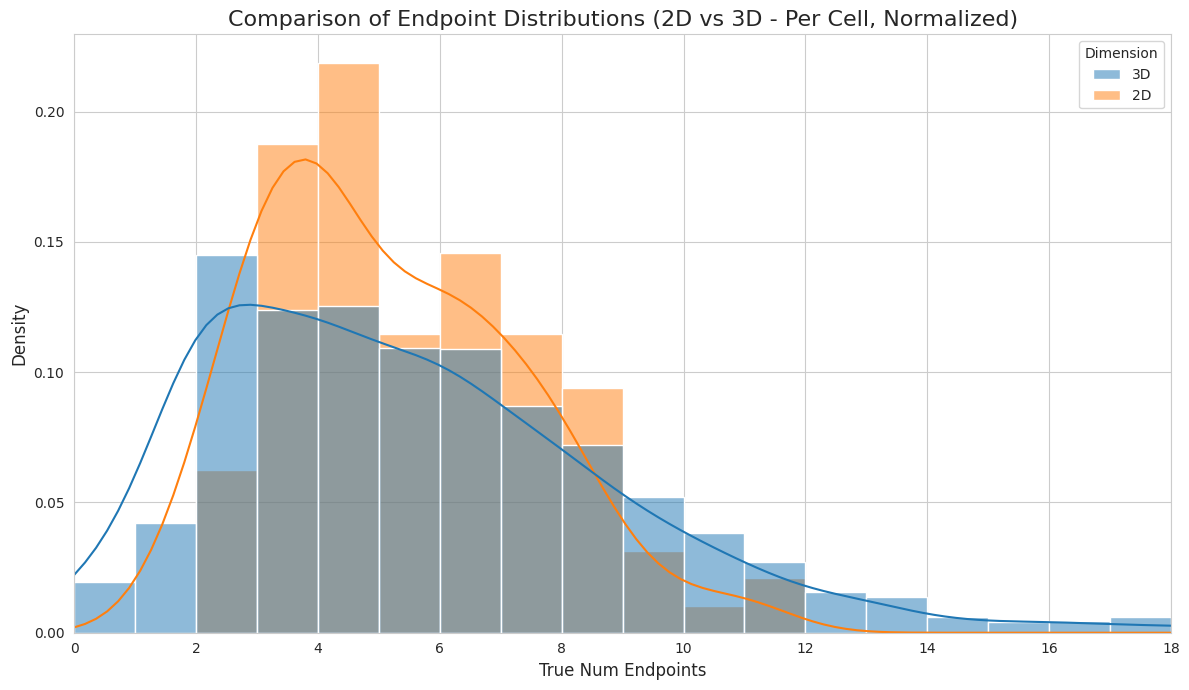

In [4]:
# --- Exploratory Histograms: True Number of Endpoints (Unified & Normalized View) ---
# This cell creates a combined histogram to directly compare the per-cell
# distributions of 2D and 3D data, normalized to show density.
# It assumes 'data_3d_df' and 'data_2d_df' have been loaded in a previous cell.

print("--- Generating Unified & Normalized Exploratory Histograms (Per-Cell Data) ---")

# Set a nice style for the plots
sns.set_style("whitegrid")
plot_metric = 'true_num_endpoints'
has_3d_data = 'data_3d_df' in locals() and not data_3d_df.empty and plot_metric in data_3d_df.columns
has_2d_data = 'data_2d_df' in locals() and not data_2d_df.empty and plot_metric in data_2d_df.columns

if not has_3d_data and not has_2d_data:
    print("Error: No valid 2D or 3D data available for plotting.")
else:
    # --- 1. Combine DataFrames for plotting ---
    plot_dfs = []
    if has_3d_data:
        df_3d_copy = data_3d_df[[plot_metric]].copy()
        df_3d_copy['Dimension'] = '3D'
        plot_dfs.append(df_3d_copy)
    if has_2d_data:
        df_2d_copy = data_2d_df[[plot_metric]].copy()
        df_2d_copy['Dimension'] = '2D'
        plot_dfs.append(df_2d_copy)

    combined_plot_df = pd.concat(plot_dfs, ignore_index=True)

    # --- 2. Determine common axis range and binning ---
    x_axis_limit = np.ceil(combined_plot_df[plot_metric].quantile(0.99))
    if x_axis_limit < 10:
        x_axis_limit = 10 
    
    bin_width = 1
    common_bins = np.arange(0, x_axis_limit + bin_width, bin_width)

    # --- 3. Create the Plot ---
    print("Plotting combined 2D vs 3D distribution (normalized)...")
    fig_hist, ax_hist = plt.subplots(figsize=(12, 7))

    # Use seaborn's histplot with the common bins and range
    sns.histplot(
        data=combined_plot_df,
        x=plot_metric,
        hue='Dimension',
        bins=common_bins,
        kde=True,
        multiple='layer',
        
        # *** KEY CHANGE: NORMALIZE THE HISTOGRAMS ***
        stat='density',      # This normalizes the bars so the area of each histogram is 1.
        common_norm=False    # This ensures each hue (2D, 3D) is normalized independently.
        
    )

    ax_hist.set_title('Comparison of Endpoint Distributions (2D vs 3D - Per Cell, Normalized)', fontsize=16)
    ax_hist.set_xlabel(format_axis_label(plot_metric), fontsize=12)
    # *** CHANGE: Update Y-axis label to reflect normalization ***
    ax_hist.set_ylabel('Density', fontsize=12)
    
    ax_hist.set_xlim(0, x_axis_limit)
    
    plt.tight_layout()
    plt.show()